In [ ]:
from PINN import PINN
from dataloader import DataloaderEuropean1D
import torch

import logging
from datetime import datetime

N_EPOCH = 4_000
LEARNING_RATE = 1e-5
HIDDEN_LAYER = 6
HIDDEN_WIDTH = 256
N_sample = 8000
PHYSICS_PENALTY = 52
BVP1_PENALTY = 8
DEVICE = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

K = 40
r = 0.05
sigma = 0.2
T = 1
S_range = [0, 160]
t_range = [0, T]

euro_call_data = DataloaderEuropean1D(t_range, S_range, K, r, sigma, DEVICE)


In [ ]:
physics_lr = PHYSICS_PENALTY
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}


In [2]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
r_ivp,r_bvp1,r_bvp2 = 1,1,1
for i in range(N_EPOCH):
    model.train();
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = euro_call_data.get_expiry_time_tensor(N_sample,r_ivp)
    print(ivp_y_tensor)
    ivp_x_tensor = ivp_x_tensor.to(DEVICE)
    ivp_y_tensor = ivp_y_tensor.to(DEVICE)
    # ivp_x_tensor = euro_call_data.normalize(ivp_x_tensor)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = euro_call_data.get_boundary_data_tensor(N_sample,r_bvp1,r_bvp2)
    bvp_x1_tensor,bvp_y1_tensor = bvp_x1_tensor.to(DEVICE),bvp_y1_tensor.to(DEVICE)
    bvp_x2_tensor,bvp_y2_tensor = bvp_x2_tensor.to(DEVICE),bvp_y2_tensor.to(DEVICE)
    # bvp_x1_tensor = euro_call_data.normalize(bvp_x1_tensor)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    # bvp_x2_tensor = euro_call_data.normalize(bvp_x2_tensor)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y2_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + BVP1_PENALTY*mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = euro_call_data.get_pde_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(DEVICE), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape).to(DEVICE), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + (0.5 * ((sigma * S1) ** 2) * d2VdS2) + (r * S1 * dVdS) - (r * y1_hat)
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.4f}")
    

In [ ]:
import pandas as pd

In [ ]:
loss_df = pd.DataFrame.from_dict(loss_history)
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")
plt.show()

In [ ]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8, subplots = True)
plt.sup_title("Training Curve for Moving Average of losses")
plt.show()

In [ ]:
from dataloader import DataloaderEuropeanMultiDimensional
import numpy as np
import torch

S_range = np.array([[0, 100] for i in range(5)])
sigma = np.ones((5,5))

DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
tmp = DataloaderEuropeanMultiDimensional((0,1), S_range, 40, 0.04, sigma, DEVICE)

expiry_x_tensor_validation, expiry_y_tensor_validation = tmp.get_expiry_time_tensor(100, 1)
lower_x_tensor_validation, lower_y_tensor_validation, upper_x_tensor_validation, upper_y_tensor_validation = tmp.get_boundary_data_tensor(
        100, 1, 1)

In [ ]:
X1_validation, y1_validation = tmp.get_pde_data_tensor(100)

In [ ]:
X1_validation = tmp.normalize(X1_validation)

In [ ]:
X1_validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = np.load("results/average_loss_different_loss.npy")
X.shape

In [ ]:
types_of_loss = ["total_loss"] #"loss_boundary","loss_pde", "loss_expiry", "loss_lower", "loss_upper"]
for idx, i in enumerate(types_of_loss, 5):
    plt.plot(X[:30, idx])
    plt.plot(X[:30, idx] + X[30:, idx])
    plt.plot(X[:30, idx] - X[30:, idx])

In [ ]:
import torch 
from src.data_generator import DataGeneratorEuropean1D
import rff
import numpy as np

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloader = DataGeneratorEuropean1D([0,1], [0,200], 40, 0.05, 0.5, DEVICE)

In [ ]:
X, y1 = dataloader.get_pde_data_tensor(128)
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=256).to(DEVICE)
X_e = encoding(X)
print(X_e.shape)
X = dataloader.normalize(X)
X_s = encoding(X)
print(X_s)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(X_e[:,0].to("cpu").detach())
plt.plot(X_s[:,0].to("cpu").detach() + 2)

In [ ]:
print(torch.max(X_e), torch.min(X_e))
print(torch.max(X_s), torch.min(X_s))

In [ ]:
import numpy as np
X1 = np.loadtxt("results/mse_data_with_fourier.txt")
print(f"{X1.mean():e}")
print(f"{X1.std():e}")
print(f"{X1.max():e}")

In [ ]:
X2 = np.loadtxt("results/rmse_data_no_fourier.txt")
print(f"{X2.mean():e}")
print(f"{X2.std():e}")

In [ ]:
(X2.mean() / X1.mean())**2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X = np.load("results_backwards/average_sigma_backwards.npy")
plt.plot(X[0,:])

In [ ]:
X = np.load("results_backwards/average_loss_backwards.npy")
print(X.shape)
n = X.shape[0] // 2
x = np.arange(0, n)
plt.plot(x, X[:n, 1])
plt.plot(x[1000:], X[1000:n, 0])
plt.yscale("log")

In [ ]:
plt.scatter(X[:,0], X[:,1], c = X[:, 2])
plt.colorbar()

In [ ]:
X = np.load("important_results_backwards/sigmas_batch.npy")
weights = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
batch_PDE=[512, 1024, 2048, 4096, 8192]
batch_target=[8, 16, 32, 64]


for i in range(0, 10):
    plt.plot(X[i, :], label = f"PDE = {batch_PDE[i // len(batch_target)]}, batch = {batch_target[i % len(batch_target)]}")

#plt.ylim([0, 0.6])
#plt.yscale("log")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
#plt.legend()

In [ ]:
X = np.load("important_results_backwards/sigmas_batch_fine.npy")
batch_PDE=[128, 256, 512, 1024]
batch_target=[32, 64, 96, 128]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(min(8, X.shape[0])):
    ax[0].plot(X[i, :], label = f"PDE = {batch_PDE[i // len(batch_target)]}, batch = {batch_target[i % len(batch_target)]}")
ax[0].legend()

for i in range(8, min(20, X.shape[0])):
    ax[1].plot(X[i, :], label = f"PDE = {batch_PDE[i // len(batch_target)]}, batch = {batch_target[i % len(batch_target)]}")

ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()
#plt.ylim([0, 0.6])
#plt.yscale("log")
#plt.legend()

In [ ]:
scale = ["0.0", "1e-06", "1e-05", "0.0001", "0.001", "0.01", "0.1", "1.0", "10", "100", "1000"]
weights = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
for i, s in enumerate(scale):
    X = np.load(f"results_backwards/average_sigma_scale_{s}.npy")
    plt.plot(X[0], label = weights[i])
plt.legend()

In [ ]:
scale = ["1.0", "10", "100", "1000"] # ["0.0", "1e-06", "1e-05", "0.0001", "0.001", "0.01", "0.1", 
weights = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]

fig, ax = plt.subplots(3,1)

for s in scale:
    X = np.load(f"results_backwards/average_loss_scale_{s}.npy")
    #print(X.shape)
    ax[0].plot(X[:10_000, 0], label = s)
    ax[1].plot(X[:10_000, 1], label = s)
    ax[2].plot(X[:10_000, 1] + X[:10_000, 0], label = s)

ax[0].legend()
ax[1].legend()
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].legend()
ax[2].set_yscale("log")

In [ ]:
from src.data_generator import DataGeneratorEuropean1D, DataGeneratorEuropeanMultiDimensional
import numpy as np
import matplotlib.pyplot as plt
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from src.PINN import PINNforwards
config = {}
config["K"] = 10
config["t_range"] = [0, 1]
config["S_range"] = np.array([[0, 100],
                              [0, 90],
                              [0, 80],
                              [0, 70]])

config["sigma"] = np.array([[0.1, 0.2, 0.1, 0.3, 0.1],
                            [0.15, 0.1, 0.4, 0.1, 0.1],
                            [0.1, 0.1, 0.3, 0.1, 0.25],
                            [0.3, 0.1, 0.5, 0.1, 0.1],
                            [0.1, 0.7, 0.1, 0.1, 0.6]])
#config["sigma"] = np.full((10,10),0.15)
#config["cov"] = config["sigma"]@config["sigma"].T
#config["cov_torch"] = torch.tensor(config["cov"]).to(DEVICE)
config["r"] = 0.04

sigma_eff_sq = 0

for i in range(config["sigma"].shape[0]):
    tmp = 0
    for j in range(config["sigma"].shape[0]):
        tmp += config["sigma"][i, j]
    sigma_eff_sq += tmp**2

sigma_eff_sq /= 4**2
print(sigma_eff_sq)
# print(sigma_eff_sq)
sigma_eff = np.sqrt(sigma_eff_sq)
def create_validation_data(dataloader:
                           DataGeneratorEuropean1D, N_validation: int, config: dict) -> dict:
    w_expiry = 1
    w_lower = 1
    w_upper = 1

    validation_data = {}

    expiry_x_tensor_validation, expiry_y_tensor_validation = dataloader.get_expiry_time_tensor(
        N_validation, w_expiry)
    expiry_x_tensor_validation_scaled = dataloader.normalize(
        expiry_x_tensor_validation)
    # config["encoder"](expiry_x_tensor_validation)

    validation_data["expiry_x_tensor_validation"] = expiry_x_tensor_validation.to(
        DEVICE)
    validation_data["expiry_x_tensor_validation_scaled"] = expiry_x_tensor_validation_scaled.to(
        DEVICE)
    validation_data["expiry_y_tensor_validation"] = expiry_y_tensor_validation.to(
        DEVICE)

    lower_x_tensor_validation, lower_y_tensor_validation, upper_x_tensor_validation, upper_y_tensor_validation = dataloader.get_boundary_data_tensor(
        N_validation, w_lower, w_upper)
    lower_x_tensor_validation_scaled = dataloader.normalize(
        lower_x_tensor_validation)

    # config["encoder"](
    #    lower_x_tensor_validation)
    upper_x_tensor_validation_scaled = dataloader.normalize(
        upper_x_tensor_validation)

    # config["encoder"](    upper_x_tensor_validation)

    validation_data["lower_x_tensor_validation"] = lower_x_tensor_validation.to(
        DEVICE)
    validation_data["lower_x_tensor_validation_scaled"] = lower_x_tensor_validation_scaled.to(
        DEVICE)
    validation_data["lower_y_tensor_validation"] = lower_y_tensor_validation.to(
        DEVICE)

    validation_data["upper_x_tensor_validation"] = upper_x_tensor_validation.to(
        DEVICE)
    validation_data["upper_x_tensor_validation_scaled"] = upper_x_tensor_validation_scaled.to(
        DEVICE)
    validation_data["upper_y_tensor_validation"] = upper_y_tensor_validation.to(
        DEVICE)

    X1_validation, y1_validation = dataloader.get_pde_data_tensor(
        N_validation)
    X1_validation_scaled = dataloader.normalize(X1_validation)
    # config["encoder"](X1_validation)

    validation_data["X1_validation"] = X1_validation

    validation_data["X1_validation_scaled"] = X1_validation_scaled

    validation_data["y1_validation"] = y1_validation

    return validation_data

In [ ]:
dataloader1D = DataGeneratorEuropean1D([0,1], [0, 600], 30, 0.04, sigma_eff, DEVICE, seed = 2024)
torch.manual_seed(2024)
np.random.seed(2024)
dataloaderMulti = DataGeneratorEuropeanMultiDimensional(
        time_range=config["t_range"], S_range=config["S_range"], K=config["K"], r=config["r"], sigma=config["sigma"], DEVICE=DEVICE, seed=2024)

validation_data = create_validation_data(
    dataloader=dataloaderMulti, N_validation=1024, config=config)

test_data = create_validation_data(
    dataloader=dataloaderMulti, N_validation=20_000, config=config)

In [ ]:
model = PINNforwards(5, 1, 256, 4, use_fourier_transform=False, sigma_FF=5.0, encoded_size=512)
model.load_state_dict(torch.load("models/learning_0.001_512.pth", weights_only=True))
pde_X_scaled = test_data["X1_validation_scaled"]
pde_X = test_data["X1_validation"]

y_pde = model(pde_X_scaled).cpu().detach().numpy().ravel()
y1 = dataloaderMulti.get_analytical_solution(pde_X[:, 1:], pde_X[:, 0])

print(np.sqrt(np.mean((y1 - y_pde)**2)))

In [ ]:
y_tmp = dataloader1D.get_analytical_solution( torch.exp(torch.mean(torch.log(pde_X[:, 1:]), dim = 1)), pde_X[:, 0])
print(np.mean(np.abs(y_tmp - y1)))

In [ ]:
X_loss = np.load("results/loss_learning_0.001_512.npy")
X_validation = np.load("results/validation_learning_0.001_512.npy")

types_of_loss = ["total_loss", "loss_boundary","loss_pde", "loss_expiry", "loss_lower", "loss_upper"]

for i in range(len(types_of_loss)):
    plt.plot(X_validation[::10, i], label = types_of_loss[i])
plt.yscale("log")
plt.legend()

In [ ]:
X_geometric = torch.exp(torch.mean(torch.log(pde_X[:, 1:]), dim = 1))
X_tmp = X_geometric.cpu().detach().numpy()
time = pde_X[:, 0].cpu().detach().numpy()
mask = np.where(time <= 1.0) 

#y_1d= dataloader1D.get_analytical_solution(X_geometric, pde_X[:, 0])
plt.scatter(time[mask], X_tmp[mask], c = y1[mask])
plt.colorbar()
plt.show()
plt.scatter(time[mask], X_tmp[mask], c = y_pde[mask])
plt.colorbar()
plt.show()

In [ ]:
from matplotlib.colors import LogNorm
mask = np.where(time <= 1.0) 
plt.scatter(time[mask], X_tmp[mask], c = np.abs(y1[mask] - y_pde[mask]), norm=LogNorm())
#plt.scatter(time[mask], X_tmp[mask], c = y_pde[mask])
print(np.sqrt(np.mean((y1[mask] - y_pde[mask])**2)))
plt.colorbar()

In [ ]:
pde_X = test_data["X1_validation"]
y1 = dataloaderMulti.get_analytical_solution(pde_X[:, 1:], pde_X[:, 0])
X_geometric = torch.exp(torch.mean(torch.log(pde_X[:, 1:]), dim = 1))
y2 = dataloader1D.get_analytical_solution(X_geometric, pde_X[:, 0])

print(np.mean((y1 - y2)**2))

In [ ]:
np.mean(G - X_geometric.cpu().detach().numpy())
#X_geometric

In [ ]:
tmp_X1 = X_geometric.cpu().detach()
tmp_X2 = pde_X.cpu().detach()
plt.scatter(tmp_X2[:, 0], tmp_X1, c = y2, label = "1D")
plt.colorbar()
plt.legend()

In [ ]:
plt.scatter(tmp_X2[:, 0], tmp_X1, c = y1, label = "Multi")
plt.colorbar()
plt.legend()

In [ ]:
import numpy as np
X = np.loadtxt("results/rmse_data_no_fourier.txt")
print(f"{X.mean():e}, {X.std():e}")
X = np.loadtxt("results/rmse_data_with_fourier.txt")
print(f"{X.mean():e}, {X.std():e}")
X = np.loadtxt("results/rmse_data_american_multiple.txt")
print(f"{X.mean():e}, {X.std():e}")

In [ ]:

for scale in ["0.0", "1e-06", "1e-05", "0.0001", "0.001", "1000", "2500"]:
    print(f"Scale: {scale}")
    X = np.loadtxt(f"results_backwards/rmse_data_scale_{scale}.txt")
    print(f"{X.mean():e}, {X.std():e}")


Scale: 0.0
1.522678e+01, 9.095798e+00
Scale: 1e-05
1.213403e-01, 2.305095e-02
Scale: 0.0001
6.449223e-02, 7.436414e-03
Scale: 0.001
8.538675e-02, 8.064675e-03
Scale: 1000
8.566787e+00, 6.340354e+00
Scale: 2500
1.388581e+01, 1.145714e+01


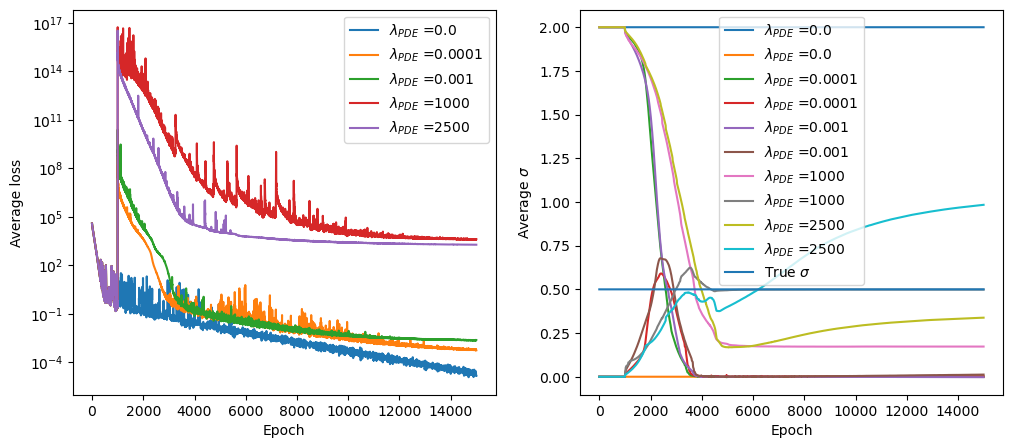

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots(1,2,figsize=(12, 5))
x = np.arange(0, 15_000, 1)

for scale in ["0.0", "0.0001", "0.001", "1000", "2500"]:
    X_loss =  np.load(f"results_backwards/average_loss_scale_{scale}.npy")
    X_loss =  X_loss[:X_loss.shape[0] // 2, :]

    X_sigma =  np.load(f"results_backwards/average_sigma_scale_{scale}.npy")
    X_sigma_std = X_sigma[X_sigma.shape[0]//2:, :]
    X_sigma = X_sigma[: X_sigma.shape[0]//2, :]

    ax[0].plot(x, X_loss[:, 1] + X_loss[:, 0], label = r"$\lambda_{PDE}$ =" +f"{scale}")
    ax[1].plot(x, X_sigma.ravel(), label = r"$\lambda_{PDE}$ =" +f"{scale}")
    ax[1].plot(x, X_sigma_std.ravel(), label = r"$\lambda_{PDE}$ =" +f"{scale}")

ax[1].plot(x, 0.5*np.ones(15_000), label =r"True $\sigma$")
ax[1].legend()
ax[0].legend()
ax[0].set_yscale("log")
ax[0].set_ylabel("Average loss")
ax[0].set_xlabel("Epoch")

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"Average $\sigma$")
plt.show()